# Unsupervised multivariate analyses: PCoA and PERMANOVA 
Authors: M Ernst, F Russo<br>
Last update: August 22, 2022<br>

In this notebook we will perform a Principal Coordinate Analysis (PCoA), also known as metric or classical Multidimensional Scaling (metric MDS) to explore and visualize patterns in an untargeted mass spectromtery-based metabolomics dataset. We will then assess statistical significance of the patterns and dispersion of different sample types using permutational multivariate analysis of variance (PERMANOVA). <br>

<b>Data</b> <br>

The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissovled organic matter (M) at different concentrations were prepared (450 (A45M); 150 (A15M); and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis. In this tutorial we are working with one of the datasets, which was acquired on a UHPLC system coupled to a Thermo Scientific Q Exactive HF Orbitrap LC-MS/MS mass spectrometer. MS/MS data were acquired in data-dependent acquisition (DDA) with fragmentation of the five most abundant ions in the spectrum per precursor scan. Data files were subsequently preprocessed using [MZmine3](http://mzmine.github.io/) and the [feature-based molecular networking workflow in GNPS](https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=d207c3a831264d61810ad69ac09b14e9).

<b>Questions</b><br>
- Can we monitor algal bloom by looking at metabolomic profiles of marine dissolved organic matter?<br>

Install and load libraries

In [1]:
# It can take some time in Google Colab
install.packages('vegan')
install.packages('ggplot2')


The downloaded binary packages are in
	/var/folders/k7/zs6jm5h95875g74l66xfxq6m0000gn/T//RtmpsPiuNO/downloaded_packages

The downloaded binary packages are in
	/var/folders/k7/zs6jm5h95875g74l66xfxq6m0000gn/T//RtmpsPiuNO/downloaded_packages


In [2]:
library(vegan)
library(ggplot2)

Warning message:
“package ‘vegan’ was built under R version 4.1.2”
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2

Warning message:
“package ‘ggplot2’ was built under R version 4.1.2”


In [3]:
# last update
Sys.time()

[1] "2022-08-24 09:45:55 CEST"

Specify where the data can be found by providing urls for the feature table and metadata. Here, we import the files directly from GitHub but you can import them from your local computer or from Google Drive as well of course. We import the cleaned and imputed (but not normalized) feature tables.

In [4]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/processed/Imputed_QuantTable_filled_with_1267_CutOff_Used_0.3.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/metadata_lab15.txt'

In [5]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [6]:
dim(ft)
dim(md)

[1] 2395   12

[1] 13  4

In [7]:
head(ft, n=2)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3488_151.112_9.684,92659.64,107936.6,90535.35,84885.34,95607.41,92654.02,88818.61,91449.84,72474.91,72892.23,86713.87,123999.6
3026_153.091_8.525,226318.05,234986.2,238839.39,139233.22,145115.98,171750.98,194286.90,189326.75,215591.77,201655.44,221566.31,235400.4


In [8]:
head(md, n=2)

,filename,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
,<chr>,<chr>,<chr>,<int>
1,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
2,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15


<b>Bring featuretable and metadata in the correct format:</b><br>

In [9]:
# name rows in metadata after filenames
rownames(md) <- md$filename

In [10]:
# how many files in the metadata are also present in the feature table
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    1    12 

In [11]:
# which file names in the metadata are not in the feature table?
setdiff(rownames(md),colnames(ft))

[1] "DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML"

The blank sample 'DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML' is not in the feature table, we thus remove it also from the metadata (it was used in the data clean up step).

In [12]:
md <- md[rownames(md) %in% colnames(ft),]

In [13]:
dim(md)

[1] 12  4

In [14]:
# transpose ft
ft <- t(ft)

In [15]:
dim(ft)

[1]   12 2395

<b>Principal coordinates analysis (PCoA)</b><br>

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph ([Gower, 2005](https://onlinelibrary.wiley.com/doi/10.1002/0470011815.b2a13070)). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.<br>

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data. <br>

This video tutorial by StatQuest summarizes nicely the basic principles of PCoA: https://www.youtube.com/watch?v=GEn-_dAyYME<br>

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table. Let's make sure this is true, using the below code (this should return TRUE).

In [16]:
identical(rownames(ft),rownames(md))
# put the rows in the feature table and metadata in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] TRUE

[1] TRUE

Now, let's scale and center the data.

In [17]:
fts <- scale(ft, scale = TRUE, center = TRUE)

Next, we will calculate pairwise distances across all samples using the Euclidean distance metric.

In [18]:
distm <- dist(fts, method = 'euclidean')

All pairwise Euclidean distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA. At first, we here color samples according to the sample types (ATTRIBUTE_Sample within our metadata)

In [19]:
table(md$ATTRIBUTE_Sample)
table(md$ATTRIBUTE_Sample_Type)
table(md$'ATTRIBUTE_Time-Point')


A15M A45M  A5M    M 
   3    3    3    3 


Sample 
    12 


 0  5 15 45 
 3  3  3  3 

In [20]:
PcoA <- cmdscale(distm, k = 2, eig = T, add = T)
PcoA_points <- as.data.frame(PcoA$points)
variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')

In [21]:
head(PcoA_points)

,PCoA1,PCoA2
,<dbl>,<dbl>
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,0.02386967,-32.03298
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,-1.55409046,-33.35346
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,-1.58329188,-31.78853
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,-56.70406721,13.81998
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,-57.27713010,12.92545
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,-55.14545459,7.93891


In [22]:
identical(rownames(PcoA_points), rownames(md))

[1] TRUE

Using the [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) library, we can plot our PCoA using the Euclidean distance (=PCA).

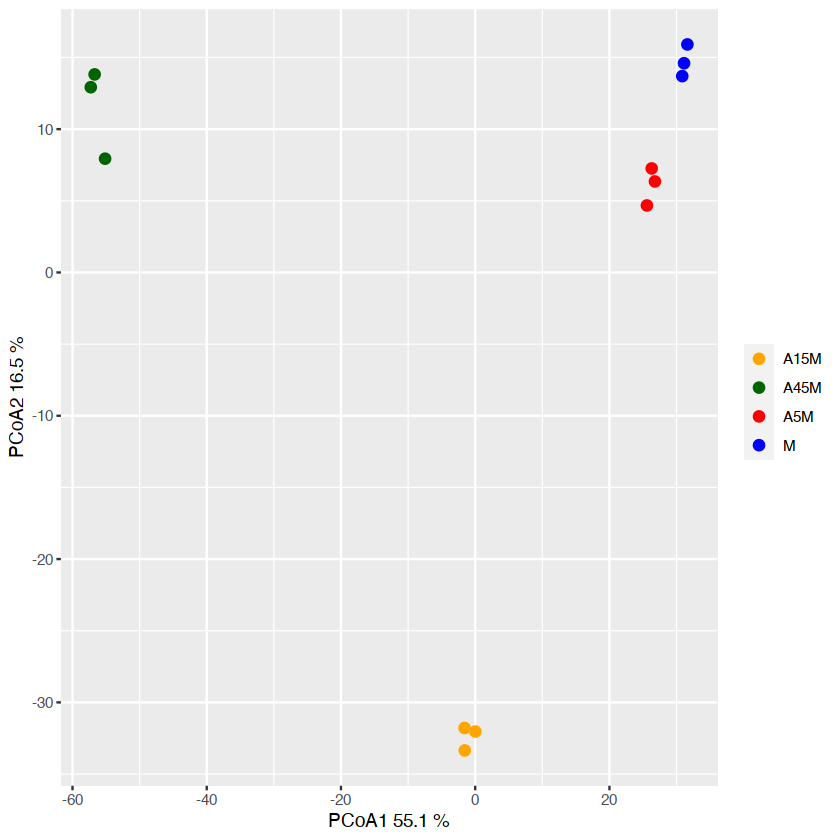

In [23]:
ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = md$ATTRIBUTE_Sample, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = c('orange','darkgreen','red','blue','black')) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            theme(legend.title=element_blank())

It looks like there is a strong separation between the different dilutions of the algae extract (A45, A15, A5, and M). But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out!

<b>Permutational multivariate analysis of variance (PERMANOVA)</b><br>

Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology ([Anderson, 2008](https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841)) but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups.<br>

The adonis2() function in the [vegan package](https://cran.r-project.org/web/packages/vegan/index.html) can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2).

In [24]:
adonres <- adonis2(distm ~ md[,colnames(md) == 'ATTRIBUTE_Sample'])

In [25]:
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"md[, colnames(md) == ""ATTRIBUTE_Sample""]",3,19774.797,0.7506091,8.026052,0.001
Residual,8,6570.203,0.2493909,NA,NA
Total,11,26345.000,1.0000000,NA,NA


The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of different dilutions of algae extract (PERMANOVA, P < 0.05, Adonis R2 = 0.7506) and that app. 75% of the variation in our data can be explained by algae concentration. That means that algal blooms could possibly be monitored using untargeted metabolomics.

<b>Perform PCoA and assess separation using PERMANOVA</b><br>

To speed up the analysis and so we don't have to rewrite the entire code when testing different parameters, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph:

In [26]:
plotPCoA <- function(ft, md, distmetric = c("euclidean", "maximum", "manhattan", "canberra", "binary", 
                                                  "minkowski"), collow = "#810f7c", colhigh ="#f7fcb9", 
                      catper = "plate", catcols = "plate", mdtype = 'categorical', 
                      cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                      title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- dist(ft, method = distmetric)
    d <- as.matrix(distm)

    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }

    PcoA <- cmdscale(distm, k =2, eig = T, add = T)
    PcoA_points <- as.data.frame(PcoA$points)
    variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    PcoA_points <- as.data.frame(PcoA_points)
    PcoA_points$Group <- md[,colnames(md) == catcols][match(rownames(PcoA_points),rownames(md))]
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_gradient(low = collow, high = colhigh,space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")+
            theme(legend.title=element_blank()) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))

        } else {

          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = cbPalette) +
            theme(legend.title=element_blank()) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))
        }
    
    print(Tr_PcoA)
}

By defining different parameters within the plotPCoA function:<br>

- <b>distmetric</b>: A distance metric of your choice, including "euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski".<br>
- <b>catper</b>: How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.<br>
- <b>catcols</b>: According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.<br>
- <b>mdtype</b>: Either 'categorical' or 'continuous', this value defines whether a continuous or categorical color scale should be used for the PCoA. <br>
- <b>cols</b>: Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.<br>
- <b>title</b>: Any title of your choice you want to give the plot.<br>

we can quickly draw the same PCoA plot as above and retrieve PERMANOVA test results at the same time.

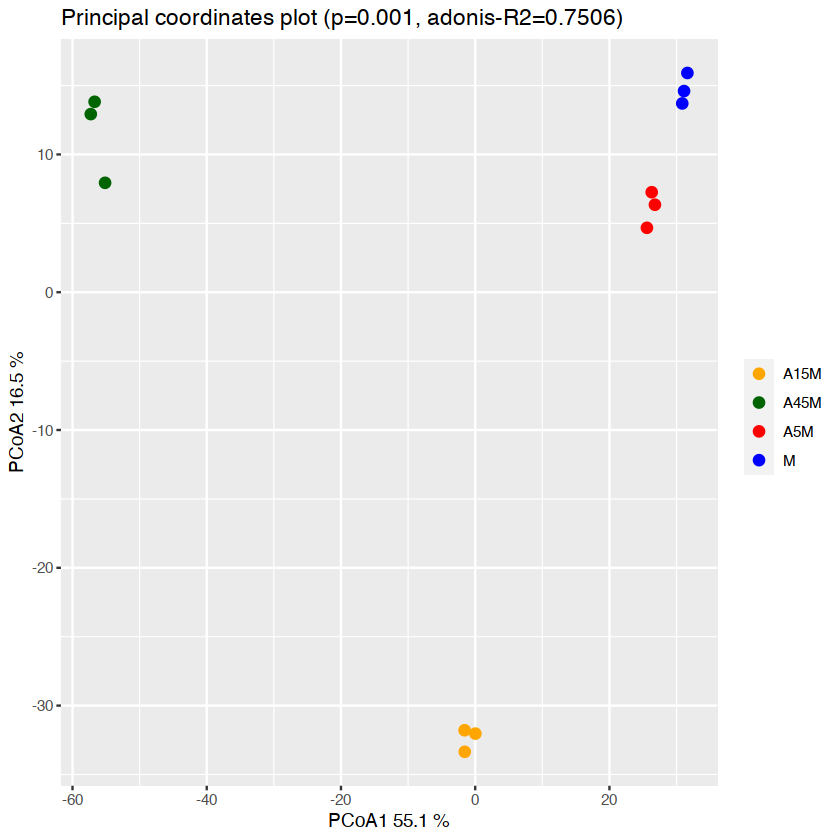

In [27]:
plotPCoA(fts, md, distmetric = "euclidean", catper = "ATTRIBUTE_Sample", catcols = "ATTRIBUTE_Sample", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

- By changing input variables of the function we just created, we can now also quickly investigate what happens if we, for example treat algae concentration as continuous data?

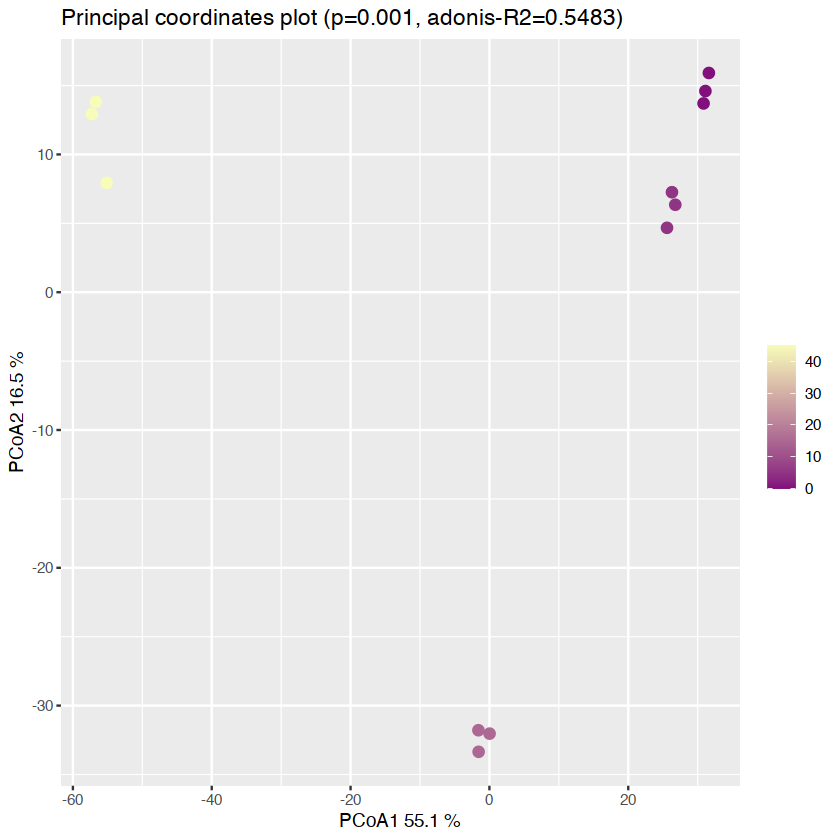

In [28]:
plotPCoA(fts, md, distmetric = "euclidean", catper = "ATTRIBUTE_Time-Point", catcols = "ATTRIBUTE_Time-Point", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

The PCoA plot looks the same, the only difference is that we can now visualize the pseudo temporal trend (algae concentration) using a color gradient. The PERMANOVA result slightly changes if we treat algae concentration as continuous rather than categorical variable. Metabolomic profiles of different algae dilutions are still significantly different but the variation in the data that can be explained by algae concentration is a bit lower, 55% (PERMANOVA, P < 0.05, Adonis R2 = 0.5483). 

- We can also test a different distance metric and look at the separation of samples. During data cleanup we replaced all zero values with the minimum value found in our feature table. We might want to opt not to impute any values but instead use a distance metric that can deal better with missing values (e.g. Canberra).

First, we replace all imputed values in the feature table with NA

In [29]:
ft_nonimp <- ft

In [30]:
ft_nonimp[ft_nonimp == min(ft_nonimp)] <- NA

In [31]:
fts_nonimp <- scale(ft_nonimp, scale = TRUE, center = TRUE)

How many missing values do we have (in %)?

In [32]:
(sum(is.na(ft_nonimp))*100)/(dim(ft)[1]*dim(ft)[2])

[1] 7.790536

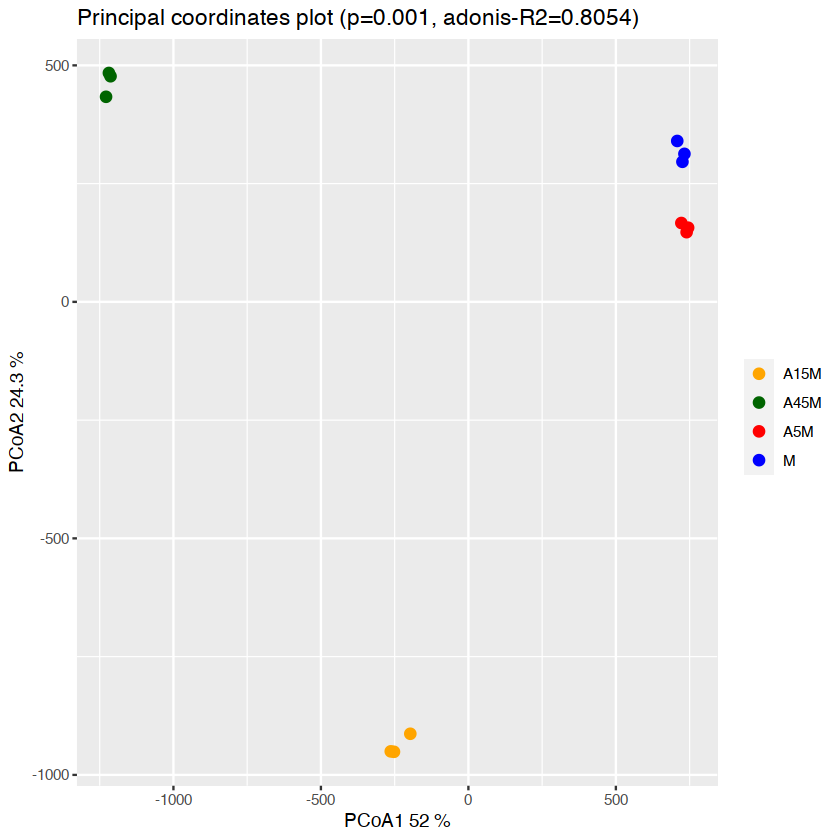

In [33]:
plotPCoA(fts_nonimp, md, distmetric = "canberra", catper = "ATTRIBUTE_Sample", catcols = "ATTRIBUTE_Sample", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

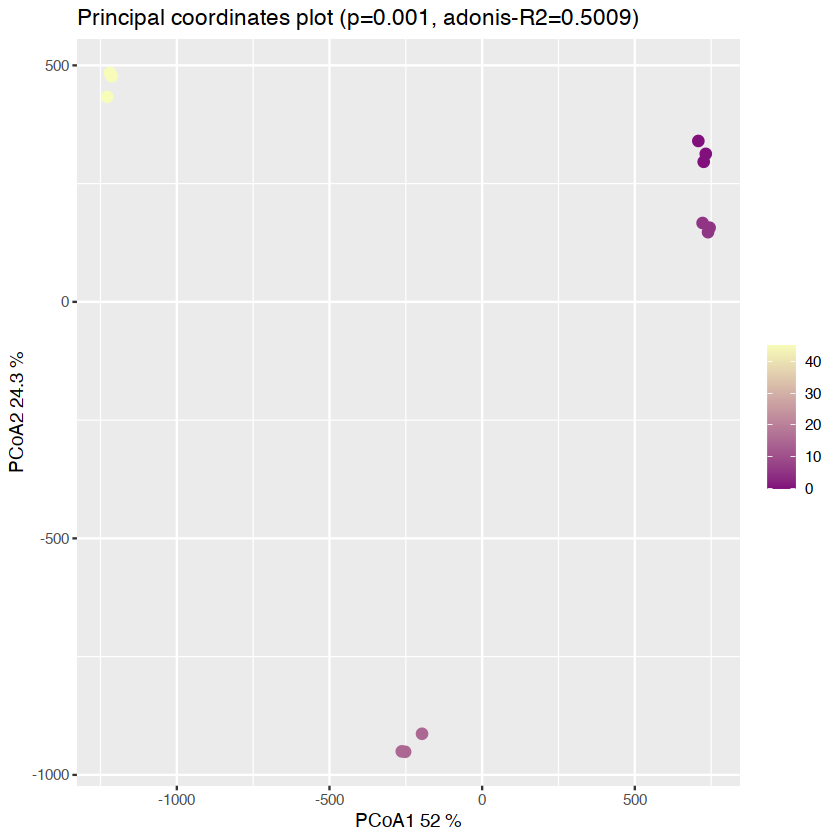

In [34]:
plotPCoA(fts_nonimp, md, distmetric = "canberra", catper = "ATTRIBUTE_Time-Point", catcols = "ATTRIBUTE_Time-Point", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

Using the Canberra distance metric, we also see a significant difference in the metabolomic profiles of different algae dilutions (PERMANOVA, P < 0.05, Adonis R2 = 0.8054 and 0.5009 respectively) with app. 80% and 50% of the variation in our data explained by algae concentration.

- Lastly, let's also test a binary metric, the Jaccard metric. When we apply the Jaccard metric we need to work with the non-imputed, non-scaled feature table, where all missing values need to be converted to 0s. A positive value will be interpreted as 1 (present) and missing values as 0 (absent).

In [35]:
ft_nonimp_0 <- ft_nonimp

In [36]:
ft_nonimp_0[is.na(ft_nonimp_0)] <- 0

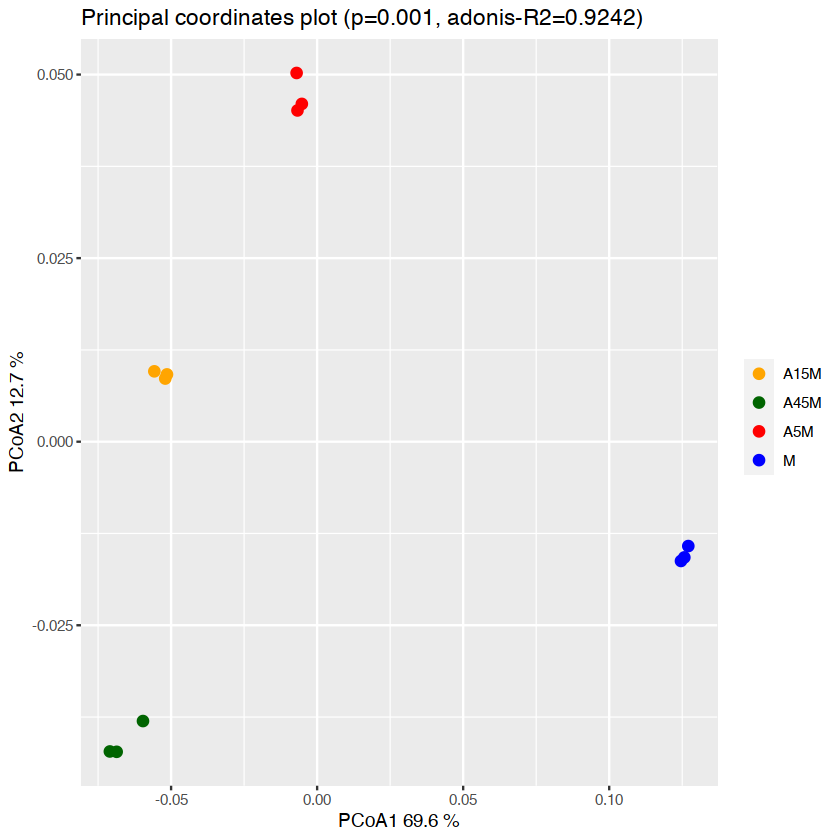

In [37]:
plotPCoA(ft_nonimp_0, md, distmetric = "binary", catper = "ATTRIBUTE_Sample", catcols = "ATTRIBUTE_Sample", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

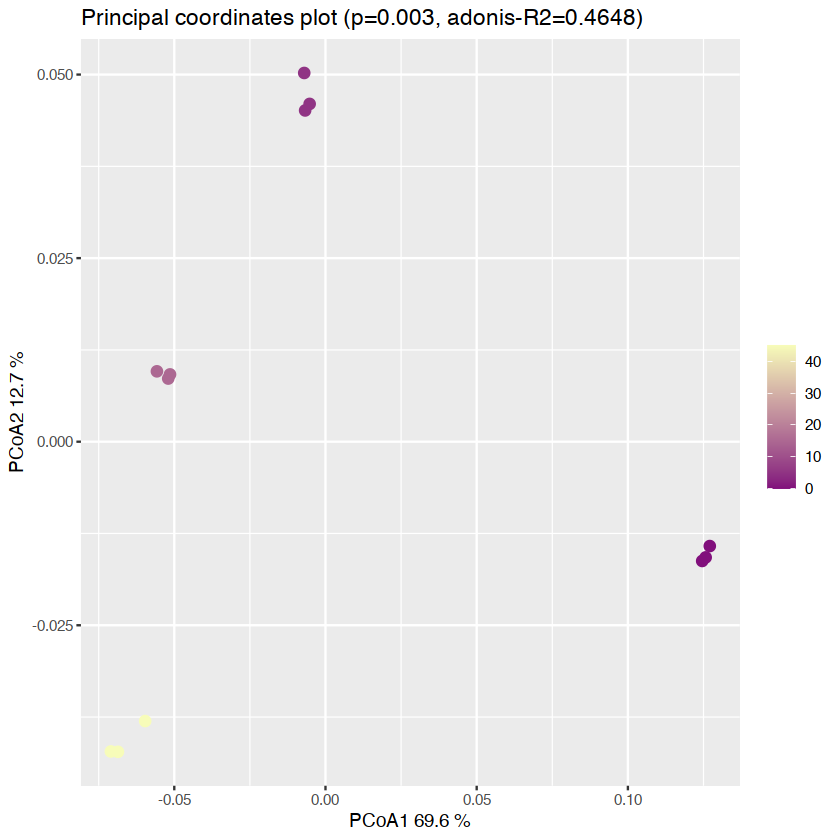

In [38]:
plotPCoA(ft_nonimp_0, md, distmetric = "binary", catper = "ATTRIBUTE_Time-Point", catcols = "ATTRIBUTE_Time-Point", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

Using the Jaccard distance metric, we also see a significant difference in the metabolomic profiles algae dilutions (PERMANOVA, P < 0.05, Adonis R2 = 0.9242 and 0.4648 respectively) with app. 92% and 46% of the variation in our data explained by algae concentration.

Now let's export the figure we want to use for our manuscript in .pdf 

In [39]:
pdf("PCoA_dom.pdf")
plotPCoA(ft_nonimp_0, md, distmetric = "binary", catper = "ATTRIBUTE_Time-Point", catcols = "ATTRIBUTE_Time-Point", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')
dev.off()

pdf 
  2

In [40]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.6   vegan_2.6-2     lattice_0.20-44 permute_0.9-5  

loaded via a namespace (and not attached):
 [1] pillar_1.6.2     compiler_4.1.1   base64enc_0.1-3  tools_4.1.1     
 [5] digest_0.6.27    uuid_0.1-4       jsonlite_1.7.2   evaluate_0.14   
 [9] lifecycle_1.0.0  tibble_3.1.4     nlme_3.1-152     gtable_0.3.0    
[13] mgcv_1.8-36      pkgconfig_2.0.3  rlang_0.4.11     Matrix_1.3-4    
[17] DBI_1.1.1        IRdisplay_1.0    IRkernel_1.2     parallel_4.1.1  
[21] fastmap_1.1.0    